In [1]:
import os
import torch
import random
from PIL import Image
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, random_split, DataLoader
import torchvision
from torchvision import transforms
import shutil

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("binh234/ccpd-preprocess")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ccpd-preprocess


In [ ]:
dataset_path=path+'/CCPD2019/ccpd_base/'
print(dataset_path)


/kaggle/input/ccpd-preprocess/CCPD2019/ccpd_base/


Image: 0459566570881-102_60-234,380_528,527-530,540_242,449_222,361_510,452-0_0_22_18_28_28_28-82-42.jpg
Image: 0205399904214-90_90-261,494_515,583-507,573_265,575_268,495_510,493-0_0_11_31_28_32_32-172-16.jpg
Image: 0137691570881-90_91-243,482_523,543-536,555_244,555_246,470_538,470-0_0_23_27_21_26_33-115-38.jpg
Image: 0313541666667-92_77-156,465_480,564-482,577_162,560_147,461_467,478-0_0_2_29_29_25_3-135-68.jpg
Image: 0178879310345-83_90-418,541_616,641-615,604_430,641_410,575_595,538-0_0_0_32_10_33_32-120-25.jpg
Image: 0152873563219-90_87-251,449_496,530-502,530_245,533_245,452_502,449-0_0_33_3_28_24_24-138-66.jpg
Image: 0301736111111-90_90-173,512_514,627-513,620_175,617_168,515_506,518-0_0_6_25_25_32_4-63-30.jpg



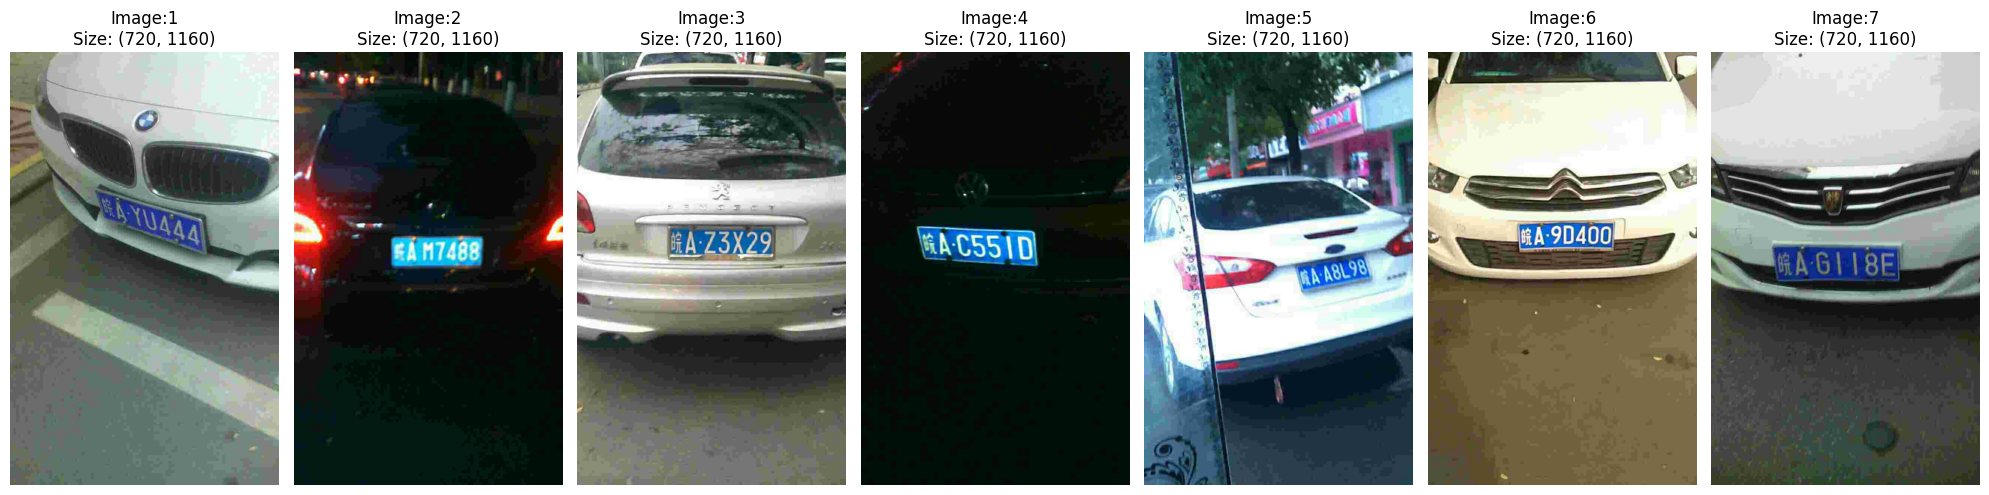

In [ ]:
def sample_images(dataset_path,num_of_images):
  image_files = random.sample([img for img in os.listdir(dataset_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))],num_of_images)
  plt.figure(figsize=(20, 6))

  for idx, img_file in enumerate(image_files):
      img_path = os.path.join(dataset_path, img_file)
      try:
            image = Image.open(img_path).convert("RGB")
            print(f"Image: {img_file}")
            plt.subplot(1, num_of_images, idx + 1)
            plt.imshow(image)
            plt.title(f"Image:{idx+1}\nSize: {image.size}")
            plt.axis("off")
      except Exception as e:
            print(f"Error{img_file}: {e}")
  print('')
  plt.tight_layout()
  plt.show()
sample_images(dataset_path,num_of_images=7)

In [ ]:
class CCPD_Dataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, image_list, transform=None):
        self.transform = transform
        self.dataset_path = dataset_path
        self.image_files = image_list

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.dataset_path, img_name)
        baseimg = Image.open(img_path)
        orig_w, orig_h = baseimg.size

        if self.transform:
            image = self.transform(baseimg.convert("RGB"))
        else:
            image = baseimg.convert("RGB")

        fields = img_name.split('-')
        box_str = fields[2]
        leftup, rightbottom = box_str.split('_')
        x1, y1 = map(int, leftup.split(','))
        x2, y2 = map(int, rightbottom.split(','))

        x_center = (x1 + x2) / 2 / orig_w
        y_center = (y1 + y2) / 2 / orig_h
        width = (x2 - x1) / orig_w
        height = (y2 - y1) / orig_h

        class_id = 0 # Car plate class

        # Placeholder for character mappings (not directly used for detection training)
        province_to_all_idx = {i: i for i in range(35)}
        alphabet_to_all_idx = {i: i for i in range(26)}
        ads_to_all_idx = {i: i for i in range(36)}

        strcharas = fields[4].split('_')
        charaslist = [int(idx) for idx in strcharas]
        provincecharidx = province_to_all_idx.get(charaslist[0], 0)
        alphabetcharidx = alphabet_to_all_idx.get(charaslist[1], 0)
        adscharidx = []
        for idx in charaslist[2:]:
            adscharidx.append(ads_to_all_idx.get(idx, 0))
        charaslistdef = [provincecharidx, alphabetcharidx] + adscharidx

        return img_name, (class_id, x_center, y_center, width, height)

In [ ]:
!pip install ultralytics

import ultralytics
ultralytics.checks() # This verifies your setup, including CUDA

Ultralytics 8.3.161 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 81.9/112.6 GB disk)


In [ ]:
def prepare_yolo_dataset(ccpd_dataset_path, output_root_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    # Ensure ratios sum to 1
    if not (train_ratio + val_ratio + test_ratio == 1.0):
        print("Warning: Train, validation, and test ratios do not sum to 1. Adjusting test_ratio.")
        test_ratio = 1.0 - train_ratio - val_ratio
        if test_ratio < 0:
            raise ValueError("Invalid ratios: train_ratio + val_ratio is greater than 1.")
        print(f"Adjusted ratios: Train={train_ratio}, Val={val_ratio}, Test={test_ratio}")

    # Create necessary directories for images and labels for all splits
    train_img_dir = os.path.join(output_root_dir, 'images', 'train')
    train_lbl_dir = os.path.join(output_root_dir, 'labels', 'train')
    val_img_dir = os.path.join(output_root_dir, 'images', 'val')
    val_lbl_dir = os.path.join(output_root_dir, 'labels', 'val')
    test_img_dir = os.path.join(output_root_dir, 'images', 'test')
    test_lbl_dir = os.path.join(output_root_dir, 'labels', 'test')

    os.makedirs(train_img_dir, exist_ok=True)
    os.makedirs(train_lbl_dir, exist_ok=True)
    os.makedirs(val_img_dir, exist_ok=True)
    os.makedirs(val_lbl_dir, exist_ok=True)
    os.makedirs(test_img_dir, exist_ok=True)
    os.makedirs(test_lbl_dir, exist_ok=True)

    # Get all image files from the source dataset path
    all_image_files = [f for f in os.listdir(ccpd_dataset_path) if f.endswith('.jpg')]
    random.shuffle(all_image_files) # Shuffle for random split

    total_images = len(all_image_files)
    train_size = int(total_images * train_ratio)
    val_size = int(total_images * val_ratio)
    # Test size gets the rest to account for potential rounding
    test_size = total_images - train_size - val_size

    train_files = all_image_files[:train_size]
    val_files = all_image_files[train_size : train_size + val_size]
    test_files = all_image_files[train_size + val_size : ]

    print(f"Total images found: {total_images}")
    print(f"Training images: {len(train_files)}")
    print(f"Validation images: {len(val_files)}")
    print(f"Test images: {len(test_files)}")

    # Use your CCPD_Dataset to parse and generate labels
    temp_dataset = CCPD_Dataset(ccpd_dataset_path, all_image_files)

    # Helper function to process and copy files
    def process_split(files, img_output_dir, lbl_output_dir):
        count = 0
        for img_name in files:
            idx = temp_dataset.image_files.index(img_name)
            _, (class_id, x_center, y_center, width, height) = temp_dataset[idx]

            shutil.copy(os.path.join(ccpd_dataset_path, img_name), os.path.join(img_output_dir, img_name))

            label_filename = img_name.replace(".jpg", ".txt")
            with open(os.path.join(lbl_output_dir, label_filename), 'w') as f:
                f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")
            count += 1
        return count

    print("Preparing training data...")
    processed_train = process_split(train_files, train_img_dir, train_lbl_dir)
    print(f"Finished preparing {processed_train} training samples.")

    print("Preparing validation data...")
    processed_val = process_split(val_files, val_img_dir, val_lbl_dir)
    print(f"Finished preparing {processed_val} validation samples.")

    print("Preparing test data...")
    processed_test = process_split(test_files, test_img_dir, test_lbl_dir)
    print(f"Finished preparing {processed_test} test samples.")

        # Create data.yaml file, now including the test split
    data_yaml_path = os.path.join(output_root_dir, 'data.yaml')
    data_yaml_content = f"""
path: {os.path.abspath(output_root_dir)}
train: images/train
val: images/val
test: images/test
nc: 1
names: ['car_plate']
"""
    with open(data_yaml_path, 'w') as f:
        f.write(data_yaml_content)
    print(f"Created data.yaml at {data_yaml_path}")



# --- SET YOUR DATASET PATH HERE ---
dataset_path = dataset_path
output_yolo_dir = '/content/yolo_ccpd_data' # Output directory for YOLO formatted data

if not os.path.exists(dataset_path):
    print(f"Error: Original CCPD dataset path not found: {dataset_path}")
    print("Please check your Google Drive mount and the exact path to your CCPD dataset folder.")
else:
    prepare_yolo_dataset(dataset_path, output_yolo_dir)



Total images found: 199996
Training images: 139997
Validation images: 29999
Test images: 30000
Preparing training data...
Finished preparing 139997 training samples.
Preparing validation data...
Finished preparing 29999 validation samples.
Preparing test data...
Finished preparing 30000 test samples.
Created data.yaml at /content/yolo_ccpd_data/data.yaml


In [ ]:
from ultralytics import YOLO

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# ================================================================
# Cell 6: Train the YOLOv8 Model
# ================================================================
print("\n--- Step 5: Training the YOLOv8 Model ---")

# Load a pre-trained YOLOv8n model (nano version, good starting point)
model = YOLO('yolov8n.pt')

# Training parameters
num_epochs = 2       # Number of training epochs. Adjust as needed.
batch_size = 4       # Number of images per batch. Adjust based on GPU memory.
img_size = 640        # Input image size for the model (e.g., 640x640).
device = 'cuda' if torch.cuda.is_available() else 'cpu' # Use GPU if available

# Define the names for your training run and project
project_name = 'yolov8_car_plate_detection'
run_name = 'ccpd_detection_run_3split_final' # Unique name for this specific training run

print(f"Training on device: {device}")
print(f"Input image size: {img_size}x{img_size}")
print(f"Training run name: {run_name} under project: {project_name}")

results = model.train(data=os.path.join(output_yolo_dir, "data.yaml"),
                      epochs=num_epochs,
                      batch=batch_size,
                      imgsz=img_size,
                      device=device,
                      name=run_name,
                      project=project_name,
                      val=True) # Enables validation during training

print("YOLOv8 Detection Training Complete!")


--- Step 5: Training the YOLOv8 Model ---
Training on device: cuda
Input image size: 640x640
Training run name: ccpd_detection_run_3split_final under project: yolov8_car_plate_detection
Ultralytics 8.3.161 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_ccpd_data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=2, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mo

train: Scanning /content/yolo_ccpd_data/labels/train... 181955 images, 0 backgrounds, 0 corrupt: 100%|██████████| 181955/181955 [09:55<00:00, 305.79it/s]


train: New cache created: /content/yolo_ccpd_data/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 1.3±1.7 ms, read: 11.2±3.3 MB/s, size: 71.6 KB)


val: Scanning /content/yolo_ccpd_data/labels/val... 55487 images, 0 backgrounds, 0 corrupt: 100%|██████████| 55487/55487 [02:50<00:00, 325.25it/s]


val: New cache created: /content/yolo_ccpd_data/labels/val.cache
Plotting labels to yolov8_car_plate_detection/ccpd_detection_run_3split_final2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to yolov8_car_plate_detection/ccpd_detection_run_3split_final2
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2     0.592G      1.022     0.5116      1.026         10        640: 100%|██████████| 45489/45489 [1:39:55<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6936/6936 [10:37<00:00, 10.89it/s]


                   all      55487      55487      0.999          1      0.995      0.774

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2     0.609G     0.9797     0.3871      1.014         11        640:  15%|█▌        | 6865/45489 [14:27<1:19:51,  8.06it/s]

In [3]:
# Suggested CCPD-Preprocess character lists:

provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
       'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

# The "O" means "no character".

#For the predicted characters, instead, a different list has to be used with ALL the characters available (The model doesn't
# make distinctions between the three fields of the plate)

all_characters = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', "O"]
print("Number of characters:", len(all_characters))

province_to_all_idx = [all_characters.index(char) for char in provinces]
alphabet_to_all_idx = [all_characters.index(char) for char in alphabets]
ads_to_all_idx = [all_characters.index(char) for char in ads]

def decode_sequence(indices, all_characters): #The function needed to return the character sequence from the indices
    return ''.join([all_characters[i] for i in indices if i < len(all_characters)])

char_to_idx = {char: idx for idx, char in enumerate(all_characters)}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}


Number of characters: 68


In [2]:
class CCPEDLicensePlateRecognitionDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, image_list, transform=None):
        self.transform = transform
        self.dataset_path = dataset_path
        self.image_files = image_list

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.dataset_path, img_name)
        image = Image.open(img_path).convert("RGB")

        fields = img_name.split('-')
        strcharas = fields[4].split('_')
        charaslist_original_ccpd_ids = [int(idx) for idx in strcharas]

        license_plate_string = ''
        try:
            for c_idx in charaslist_original_ccpd_ids:
                if c_idx < len(all_characters):
                    license_plate_string += all_characters[c_idx]
                else:
                    # Handle invalid indices if they occur (e.g., by mapping to 'O' or raising error)
                    license_plate_string += 'O' # Or skip
                    print(f"Warning: Index {c_idx} out of bounds for `all_characters` in {img_name}")
        except IndexError:
             print(f"Error parsing {img_name}: Character index out of bounds.")
             return None, None # Signal to filter this item
        except KeyError as e:
            print(f"Error parsing {img_name}: Missing character mapping for {e}")
            return None, None

        if not license_plate_string:
            return None, None

        label_sequence = [char_to_idx[char] for char in license_plate_string]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label_sequence, dtype=torch.long)

In [5]:
class Focus(nn.Module):
    #The focus model of the IGFE where it slice and concatenate
    #The usual shape is (B, C, H, W)
    def __init__(self, in_channels, out_channels):
        super(Focus, self).__init__()
        self.conv = nn.Conv2d(in_channels * 4, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.LeakyReLU(0.1)

    def forward(self, x):
        top_left = x[..., ::2, ::2]
        top_right = x[..., ::2, 1::2]
        bottom_left = x[..., 1::2, ::2]
        bottom_right = x[..., 1::2, 1::2]
        x = torch.cat([top_left, top_right, bottom_left, bottom_right], dim=1)
        return self.act(self.bn(self.conv(x)))

class ConvDownSampling(nn.Module):
    # as the paper mentioned we need to use conv + BN + LeakyReLU with stride 2 for downsampling
    def __init__(self, in_channels, out_channels):
        super(ConvDownSampling, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1)
        )

    def forward(self, x):
        return self.block(x)

class ResBlock(nn.Module):
    #the residual block
    def __init__(self, channels):
        super(ResBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(0.1),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channels)
        )
        self.act = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.act(self.block(x) + x)

class IGFE(nn.Module):
    #here we concatenate the blocks as mentioned in the paper
    def __init__(self):
        super(IGFE, self).__init__()
        self.focus = Focus(3, 64)

        self.res1 = ResBlock(64)
        self.res2 = ResBlock(64)
        self.down1 = ConvDownSampling(64, 128)

        self.res3 = ResBlock(128)
        self.res4 = ResBlock(128)
        self.down2 = ConvDownSampling(128, 256)

        self.final_conv = nn.Conv2d(256, 512, kernel_size=1)

    def forward(self, x):
        x = self.focus(x)        # (B, 64, 24, 72)
        x = self.res1(x)
        x = self.res2(x)
        x = self.down1(x)        # (B, 128, 12, 36)
        x = self.res3(x)
        x = self.res4(x)
        x = self.down2(x)        # (B, 256, 6, 18)
        x = self.final_conv(x)   # (B, 512, 6, 18)
        return x



In [6]:
class PositionalEncoding(nn.Module):
    #add trainable parameters as positional embiddings
    def __init__(self, d_model, height, width):
        super(PositionalEncoding, self).__init__()
        self.positionalembeddings = nn.Parameter(torch.randn(1, d_model, height, width))  # (1, C, H, W)

    def forward(self, x):
        return x + self.positionalembeddings


In [7]:
class EncoderBlock(nn.Module):
    def __init__(self, d_model, num_heads):
        super(EncoderBlock, self).__init__()
        self.conv1 = nn.Conv2d(d_model, d_model * 2, kernel_size=1)
        self.attn = nn.MultiheadAttention(d_model * 2, num_heads, batch_first=True)
        self.conv2 = nn.Conv2d(d_model * 2, d_model, kernel_size=1)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        #x is in the form (B, C, H, W)
        B, C, H, W = x.shape
        x = self.conv1(x)                      # (B, C*2, H, W)
        x_flat = x.flatten(2).permute(0, 2, 1) # (B, H*W, C*2)  HERE WE SHOULD PERFORM Permute to do attention block
        attn_out, _ = self.attn(x_flat, x_flat, x_flat)  # (B, H*W, C*2)
        attn_out = attn_out.permute(0, 2, 1).view(B, C * 2, H, W)
        x = self.conv2(attn_out)               # (B, C, H, W)
        x = x + self.norm(x.flatten(2).transpose(1, 2)).transpose(1, 2).view(B, C, H, W)
        return x


In [8]:
#here we concatenate the pre prepared blocks
class Encoder(nn.Module):
    def __init__(self, d_model=512, num_heads=8, num_layers=3):
        super(Encoder, self).__init__()
        self.pos_enc = PositionalEncoding(d_model, height=6, width=18)
        self.layers = nn.ModuleList([
            EncoderBlock(d_model, num_heads) for _ in range(num_layers)
        ])

    def forward(self, x):
        x = self.pos_enc(x)
        for layer in self.layers:
            x = layer(x)
        return x  # (B, 512, 6, 18)


In [ ]:
class FeedForward(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.ReLU(),
            nn.Linear(d_model * 4, d_model)
        )

    def forward(self, x):
        return self.ff(x)


In [4]:
class DecoderBlock(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, num_heads, batch_first=True)
        self.cross_attn = nn.MultiheadAttention(d_model, num_heads, batch_first=True)
        self.ff = FeedForward(d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)

    def forward(self, targetSeq, memory, targetseq_mask=None):
        # Self-attention with mask
        #create a local variable
        local_targetSeq, _ = self.self_attn(targetSeq, targetSeq, targetSeq, attn_mask=targetseq_mask)
        targetSeq = self.norm1(targetSeq + local_targetSeq)

        # Cross-attention with encoder output
        local_targetSeq, _ = self.cross_attn(targetSeq, memory, memory)
        targetSeq = self.norm2(targetSeq + local_targetSeq)

        # Feedforward
        local_targetSeq = self.ff(targetSeq)
        targetSeq = self.norm3(targetSeq + local_targetSeq)

        return targetSeq


In [ ]:
class ParallelDecoder(nn.Module):
    def __init__(self, d_model=512, num_heads=8, num_layers=3, max_seq_len=18, num_classes=len(all_characters)):
        super().__init__()
        self.char_embed = nn.Embedding(num_classes, d_model)
        self.pos_embed = nn.Parameter(torch.randn(1, max_seq_len, d_model))
        self.decoder_layers = nn.ModuleList([
            DecoderBlock(d_model, num_heads) for _ in range(num_layers)
        ])
        self.output_proj = nn.Linear(d_model, num_classes)
  #tgt is the target sequence
    def forward(self, memory, tgt_seq, tgt_mask=None):

        tgt = self.char_embed(tgt_seq) + self.pos_embed  # (B, seq_len, d_model)
        for layer in self.decoder_layers:
            tgt = layer(tgt, memory, tgt_mask)

        return self.output_proj(tgt)  # (B, seq_len, num_classes)


In [ ]:
class PDLPR(nn.Module):
    def __init__(self, num_classes, d_model=512, num_heads=8, num_layers=3, max_seq_len=18):
        super(PDLPR, self).__init__()
        self.igfe = IGFE()  # Feature extractor
        self.encoder = Encoder(d_model=d_model, num_heads=num_heads, num_layers=num_layers)
        self.decoder = ParallelDecoder(
            d_model=d_model,
            num_heads=num_heads,
            num_layers=num_layers,
            max_seq_len=max_seq_len,
            num_classes=len(all_characters)
        )
        self.max_seq_len = max_seq_len

    def forward(self, images, tgt_seq, tgt_mask=None):
        """
        images: input license plate images (B, 3, 48, 144)
        tgt_seq: target token indices (B, max_seq_len)
        tgt_mask: optional causal mask (max_seq_len, max_seq_len)
        """
        features = self.igfe(images)  # (B, 512, 6, 18)
        enc_out = self.encoder(features)  # (B, 512, 6, 18)

        # Flatten encoder output to (B, 108, 512)
        B, C, H, W = enc_out.shape
        memory = enc_out.view(B, C, H * W).permute(0, 2, 1)  # (B, 108, 512)

        logits = self.decoder(memory, tgt_seq, tgt_mask)  # (B, max_seq_len, num_classes)
        return logits


In [4]:
def collate_fn(batch):
    batch = [item for item in batch if item[0] is not None]
    if not batch:
        return None, None, None, None

    images = []
    targets = []
    target_lengths = []

    for img, label in batch:
        images.append(img)
        targets.extend(label.tolist())
        target_lengths.append(len(label))

    images = torch.stack(images)
    targets = torch.tensor(targets, dtype=torch.long)
    target_lengths = torch.tensor(target_lengths, dtype=torch.long)

    input_lengths = torch.full((images.size(0),), 18, dtype=torch.long)

    return images, targets, input_lengths, target_lengths